In [56]:
import pandas as pd
import numpy as np
from abc import ABC, abstractmethod
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from scipy.sparse import csr_matrix, hstack, vstack
import lightgbm as lgb

from enum import Enum
class ModelName(Enum):
    XGB = 1
    NBXGB = 2
    LGB = 3
    NBLGB = 4
    LOGREG = 5
    NBSVM = 6
    NBLSVC = 7
    RF = 8 # random forest
    RNN = 9
    ONESVC = 10
    ONELOGREG = 11


class BaseLayerEstimator(ABC):
    
    def _pr(self, y_i, y, train_features):
        p = train_features[np.array(y==y_i)].sum(0)
        return (p + 1) / (np.array(y == y_i).sum() + 1)
    
    def _nb(self, x_train, y_train):
        assert isinstance(y_train, pd.DataFrame)
        r = {}
        for col in y_train.columns:
            print('calculating naive bayes for {}'.format(col))
            r[col] = np.log(self._pr(1, y_train[col].values, x_train) / self._pr(0, y_train[col], x_train))
        return r
    
    @abstractmethod
    def train(self, x_train, y_train):
        """
        Params:
            x_train: np array
            y_train: pd series
        """
        pass
    
    @abstractmethod
    def predict(self, x_train):
        pass
    
            

from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

class RnnBLE(BaseLayerEstimator):
    def __init__(self, window_length, n_features, label_cols, rnn_units=50, dense_units=50, dropout=0.1, 
                 mode='LSTM', bidirection=True, load_model=False, load_model_file=None):
        self._model = RnnBLE.get_lstm_model(window_length, n_features, label_cols, rnn_units, 
                                            dense_units, dropout, mode, bidirection, load_model, load_model_file)
        
    @staticmethod
    def get_lstm_model(window_length, n_features, label_cols, rnn_units, dense_units, 
                       dropout, mode, bidirection, load_model=False, load_model_file=None):
        input = Input(shape=(window_length, n_features))
        rnn_layer = LSTM(rnn_units, return_sequences=True, dropout=dropout, recurrent_dropout=dropout)
        if mode == 'GRU':
            rnn_layer = GRU(rnn_units, return_sequences=True, dropout=dropout, recurrent_dropout=dropout)
        if bidirection:
            x = Bidirectional(rnn_layer)(input)
        else:
            x = rnn_layer(input)
        x = GlobalMaxPool1D()(x)
        x = Dense(dense_units, activation='relu')(x)
        x = Dropout(dropout)(x)
        x = Dense(len(label_cols), activation='sigmoid')(x)
        model = Model(inputs=input, outputs=x)
        
        if (load_model):
            model.load_weights(load_model_file)
        
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        return model 
    
    
    def train(self, epochs, x_train=None, y_train=None, batch_size=None, callbacks=None, 
              validation_split=0.0, validation_data=None, data_gen=None, training_steps_per_epoch=None):
        if data_gen is None:
            if x_train is None or y_train is None or batch_size is None:
                raise ValueError('Since not training with data generator, please provide: x_train, y_train, batch_size')
            print('training without datagen')
            self._model.fit(x_train, y_train, batch_size=batch_size, validation_split=validation_split, epochs=epochs, callbacks=callbacks)
            return self._model # for chaining
        else:
            if training_steps_per_epoch is None:
                raise ValueError('training_steps_per_epoch can not be None when using data_gen')
            # with generator:
            print('training with datagen')
    
            self._model.fit_generator(
                generator=data_gen,
                steps_per_epoch=training_steps_per_epoch, 
                epochs=epochs, 
                validation_data=validation_data, # (x_val, y_val) 
                callbacks=callbacks
            )
            return self._model
            
    
    def predict(self, x, load_model_file=None):
        if load_model_file is not None:
            self._model.load_weights(load_model_file)
        return self._model.predict(x, verbose=1)#, batch_size=1024)
    


In [20]:
from fastText import load_model

class FastTextDataGenerator():
    # class variables
    print('loading FastText model...', flush=True) # flush set true has no effect?
    ft_model_path = '/home/kai/data/resources/FastText/wiki.en.bin'
    ft_model = load_model(ft_model_path)
    n_features = FastTextDataGenerator.ft_model.get_dimension()
    print('fasttext model loaded. embedding dimemsion: {}'.format(n_features))

    
    def __init__(self, df, label_cols, text_column_name, window_length, batch_size, shuffle=True):
        """
        Params:
            df: (dataframe) at least contains a text column and label columns
            label_cols: (list) names of label columns
                        e.g.: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
            text_column_name: (str) text for faxttext embedding
                        e.g.: comment or comment_text_cleaned
            window_length: (int) pick at most the first n words from a text
            batch_size: (int) how large to generate at each batch
            shuffle: (boolean)  whether to shuffle df each epoch 
        Returns:
            (tuple) contains training data and labels of the batch size
            
        """        
        #self._ft_model = load_model(ft_model_path)
#         self._n_features = FastTextDataGenerator.ft_model.get_dimension()
#         print('fasttext model loaded. embedding dimemsion: {}'.format(self._n_features))
        
        self._df = df
        self._label_cols = label_cols
        self._text_column_name = text_column_name
        self._window_length = window_length
        self._batch_size = batch_size
        self._shuffle = shuffle
        self.training_steps_per_epoch = round(len(df) / batch_size)
        
        
    def load_new_ft_model(self, new_ft_model_path):
        print('loading new model...', flush=True) 
        FastTextDataGenerator.ft_model = load_model(new_ft_model_path)
        FastTextDataGenerator.n_features = FastTextDataGenerator.ft_model.get_dimension()
        print('fasttext model loaded. embedding dimemsion: {}'.format(FastTextDataGenerator.n_features))

            
    def data_gen(self):
        """
        Given a raw dataframe, generates infinite batches of FastText vectors.
        """
        batch_i = 0 # Counter inside the current batch vector
        batch_x = None # The current batch's x data
        batch_y = None # The current batch's y data

        while True: # Loop forever
            if self._shuffle:
                self._df = self._df.sample(frac=1) 

            for i, row in self._df.iterrows():
                comment = row[self._text_column_name][0] # add [0] to get the string from the pd.Series 

                if batch_x is None:
                    batch_x = np.zeros((self._batch_size, self._window_length, FastTextDataGenerator.n_features), dtype='float32')
                    batch_y = np.zeros((self._batch_size, len(self._label_cols)), dtype='float32')
                
                batch_x[batch_i] = FastTextDataGenerator.text_to_vector(comment, self._window_length)
                batch_y[batch_i] = row[self._label_cols].values
                batch_i += 1

                if batch_i == self._batch_size:
                    # Ready to yield the batch
                    yield batch_x, batch_y
                    batch_x = None
                    batch_y = None
                    batch_i = 0

    @staticmethod
    def text_to_vector(text, window_length):
        """
        Given a string, normalizes it, then splits it into words and finally converts
        it to a sequence of word vectors.
        """
        text = FastTextDataGenerator.normalize(text)
        words = text.split()
        window = words[-window_length:]

        x = np.zeros((window_length, FastTextDataGenerator.n_features))

        for i, word in enumerate(window):
            x[i, :] = FastTextDataGenerator.ft_model.get_word_vector(word).astype('float32')

        return x

    @staticmethod
    def normalize(s):
        """
        Given a text, cleans and normalizes it. Feel free to add your own stuff.
        """
        #s = s.lower()
        # Replace ips
        #s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
        # Isolate punctuation
        #s = re.sub(r'([\'\"\.\(\)\!\?\-\\\/\,])', r' \1 ', s)
        # Remove some special characters
        #s = re.sub(r'([\;\:\|•«\n])', ' ', s)
        # Replace numbers and symbols with language
        s = s.replace('&', ' and ')
        s = s.replace('@', ' at ')
        s = s.replace('0', ' zero ')
        s = s.replace('1', ' one ')
        s = s.replace('2', ' two ')
        s = s.replace('3', ' three ')
        s = s.replace('4', ' four ')
        s = s.replace('5', ' five ')
        s = s.replace('6', ' six ')
        s = s.replace('7', ' seven ')
        s = s.replace('8', ' eight ')
        s = s.replace('9', ' nine ')
        return s

    @staticmethod
    def df_to_data(df, text_column_name, window_length):
        """
        Convert a given dataframe to a dataset of inputs for the NN.
        """
        x = np.zeros((len(df), window_length, FastTextDataGenerator.n_features), dtype='float32')

        for i, comment in enumerate(df[text_column_name].values):
            x[i, :] = FastTextDataGenerator.text_to_vector(comment, window_length)

        return x
    

loading FastText model...
fasttext model loaded. embedding dimemsion: 300


In [21]:
import gc
gc.collect()

1039

In [3]:
PATH = '~/data/toxic/data/'

train = pd.read_csv(PATH + 'cleaned_train.csv')
#train = pd.read_csv('/home/kai/data/wei/Toxic/data/Shiyi_training.csv').fillna('na')

test = pd.read_csv(PATH + 'cleaned_test.csv')

#train = train.head(1000)
#test = test.head(1000)

train_sentence = train['comment_text_cleaned']
test_sentence = test['comment_text_cleaned']

text = pd.concat([train_sentence, test_sentence])

print(train.shape)
print(test.shape)

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

(159571, 27)
(153164, 21)


In [4]:
train = train[:5000]
test = test[:5000]

In [25]:
temp = FastTextDataGenerator.df_to_data(test, 'comment_text_cleaned', 200)

In [29]:
from base_layer_utils import BaseLayerDataRepo, BaseLayerResultsRepo, ModelName

bldr = BaseLayerDataRepo()
rnn_data_id = '_fasttext_datagen_200_300'
compatible_models= [ModelName.RNN]
bldr.add_data(rnn_data_id, train['comment_text_cleaned'].values.reshape(-1,1), temp, train[label_cols], label_cols, compatible_models, True)

In [30]:
print(bldr)

data_id: _ep1_fasttext_datagen_200_300 
	x_train: (5000, 1)	x_test: (5000, 200, 300)
	y_train type: <class 'pandas.core.frame.DataFrame'>
	compatible_model: {<ModelName.RNN: 9>}
 


In [31]:
data = bldr.get_data('_ep1_fasttext_datagen_200_300')

In [32]:
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']

x_train.reshape(-1,1).shape, y_train.shape

np.hstack((x_train, y_train)).shape

In [35]:
df_for_data_gen = pd.DataFrame(np.hstack((x_train, y_train)), columns=[['comment']+label_cols])

In [36]:
ft_data_gen = FastTextDataGenerator(df_for_data_gen, label_cols, 'comment', 200, 32, True)

In [37]:
ft_data_gen.training_steps_per_epoch

156

In [41]:
model_file = 'obj/rnn_models/model1'            
checkpoint = ModelCheckpoint(model_file, monitor='acc', verbose=1)#, save_best_only=True, mode='min')
#earlystopping = EarlyStopping(monitor="acc", mode="max", patience=2)
callbacks = [checkpoint]#, earlystopping]

In [57]:
rnn_m = RnnBLE(200, 300, label_cols, load_model=True, load_model_file=model_file)

In [58]:
rnn_m.train(1, data_gen=ft_data_gen.data_gen(), training_steps_per_epoch=ft_data_gen.training_steps_per_epoch, callbacks=callbacks)

training with datagen
Epoch 1/1
155/156 [============================>.] - ETA: 0s - loss: 0.0971 - acc: 0.9670
Epoch 00001: saving model to obj/rnn_models/model1
156/156 [==============================] - 71s 454ms/step - loss: 0.0966 - acc: 0.9672


In [44]:
rnn_m.train(1, data_gen=ft_data_gen.data_gen(), training_steps_per_epoch=ft_data_gen.training_steps_per_epoch, callbacks=callbacks)

training with datagen
Epoch 1/1
155/156 [============================>.] - ETA: 0s - loss: 0.1758 - acc: 0.9518
Epoch 00001: saving model to obj/rnn_models/model1
156/156 [==============================] - 71s 456ms/step - loss: 0.1753 - acc: 0.9520


In [ ]:
rnn_m.

In [59]:
preds = rnn_m.predict(x_test)

5000/5000 [==============================] - 15s 3ms/step


In [50]:
pred1 = rnn_m.predict(x_test, load_model_file=model_file)

5000/5000 [==============================] - 16s 3ms/step


In [52]:
preds[:, 0]

(5000,)

In [53]:
import matplotlib.pyplot as plt

In [54]:
%matplotlib inline

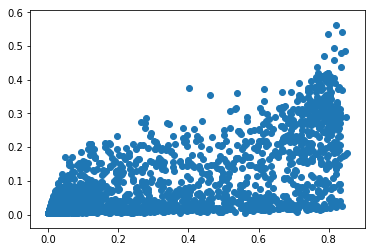

In [60]:
plt.scatter(preds[:,0], pred1[:,0])